In [2]:
import numpy as np
import matplotlib.pyplot as plt
from random import randint, seed

import tensorflow as tf
import keras.backend as K
from tensorflow.keras import models, Input
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Flatten, TimeDistributed, RepeatVector

In [14]:
## Functions to generate a dummy Seq2Seq Dataset, 

# generate a sequence of random integers
def generate_sequence(length, n_unique):
    return [randint(0, n_unique-1) for _ in range(length)]


# one hot encode a sequence
def one_hot_encode(sequence, n_unique):
    encoding = list()
    for value in sequence:
        vector = [0 for _ in range(n_unique)]
        vector[value] = 1
        encoding.append(vector)
    return np.array(encoding)


# decode a one hot encoded string
def one_hot_decode(encoded_seq):
    return [np.argmax(vector) for vector in encoded_seq]


# prepare data for the LSTM. Input is a sequence of numbers, output is reverse of that sequence.
def get_reversed_pairs(time_steps, vocabulary_size, verbose=False):
    # generate random sequence
    sequence_in = generate_sequence(time_steps, vocabulary_size)
    sequence_out = sequence_in[::-1]
    
    # one hot encode
    X = one_hot_encode(sequence_in, vocabulary_size)
    y = one_hot_encode(sequence_out, vocabulary_size)
    
    # reshape as 3D
    X = X.reshape((1, X.shape[0], X.shape[1]))
    y = y.reshape((1, y.shape[0], y.shape[1]))

    if(verbose):
        print('\nSample X and y')
        print('\nIn raw format:')
        print('X[0] = %s, \ny[0] = %s' % (one_hot_decode(X[0]), one_hot_decode(y[0])))
        print('\nIn one_hot_encoded format:')
        print('X[0] = %s' % (X[0]))
        print('\ny[0] = %s' % (y[0]))
    return X,y


def create_dataset(train_size, test_size, time_steps, vocabulary_size, verbose=False):
    pairs = [get_reversed_pairs(time_steps,vocabulary_size) for _ in range(train_size)]
    pairs = np.array(pairs).squeeze()
    X_train = pairs[:,0]
    y_train = pairs[:,1]
    pairs = [get_reversed_pairs(time_steps,vocabulary_size) for _ in range(test_size)]
    pairs = np.array(pairs).squeeze()
    X_test = pairs[:,0]
    y_test = pairs[:,1]	

    if(verbose):
        print('\nGenerated sequence datasets as follows')
        print('X_train.shape: ', X_train.shape, 'y_train.shape: ', y_train.shape)
        print('X_test.shape: ', X_test.shape, 'y_test.shape: ', y_test.shape)

    return X_train, y_train, X_test, y_test

In [4]:
## Function to train & test a given model (Early Stopping monitor 'val_loss')

def train_test(model, X_train, y_train , X_test, y_test, epochs=500, verbose=0):
    
    # patient early stopping
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
    
    # train the model
    print('training for ',epochs,' epochs begins with EarlyStopping while monitoring val_loss...')
    history = model.fit(X_train, y_train, validation_split=0.1, epochs=epochs, verbose=verbose, callbacks=[es])
    print(epochs,' epoch training finished...')

    
    # evaluate the model
    _, train_acc = model.evaluate(X_train, y_train, verbose=0)
    _, test_acc = model.evaluate(X_test, y_test, verbose=0)
    
    print('\nPREDICTION ACCURACY (%):')
    print('Train: %.3f, Test: %.3f' % (train_acc*100, test_acc*100))

    
    # plotting the training history
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(model.name + ' accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(model.name+' loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    # spot check some examples
    print('Example predictions...')
    for _ in range(10):
        X, y = get_reversed_pairs(n_timesteps_in, n_features)
        yhat = model.predict(X, verbose=0)
        print('Input: ', one_hot_decode(X[0]),
              'Expected:', one_hot_decode(y[0]), 
              'Predicted', one_hot_decode(yhat[0]),
              '', np.array_equal(one_hot_decode(y[0]), one_hot_decode(yhat[0])) )


In [5]:
# Configure parameters of the model and dataset

# each input sample will have 4 values
n_timesteps = 4

# each value is one_hot_encoded with 10 features (i.e. 0/1)
n_features = 10   

# generate random sequence
X,y = get_reversed_pairs(n_timesteps_in,  n_features, verbose=True)

# generate datasets
train_size= 20000 
test_size = 200 

X_train, y_train, X_test, y_test = create_dataset(train_size, test_size, 
                                                  n_timesteps_in, n_features, verbose=True)


Sample X and y

In raw format:
X[0]=[1, 7, 2, 8], y[0]=[8, 2, 7, 1]

In one_hot_encoded format:
X[0]=[[0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0]]
y[0]=[[0 0 0 0 0 0 0 0 1 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 1 0 0 0 0 0 0 0 0]]

Generated sequence datasets as follows
X_train.shape:  (20000, 4, 10) y_train.shape:  (20000, 4, 10)
X_test.shape:  (200, 4, 10) y_test.shape:  (200, 4, 10)


### Multi-Layer Perceptron network

We will train a simple Multilayer Perceptron Network on the generated dataset to see how the model performs on it.

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 4, 10)]           0         
_________________________________________________________________
dense_5 (Dense)              (None, 4, 256)            2816      
_________________________________________________________________
dense_6 (Dense)              (None, 4, 128)            32896     
_________________________________________________________________
dense_7 (Dense)              (None, 4, 64)             8256      
_________________________________________________________________
dense_8 (Dense)              (None, 4, 10)             650       
Total params: 44,618
Trainable params: 44,618
Non-trainable params: 0
_________________________________________________________________


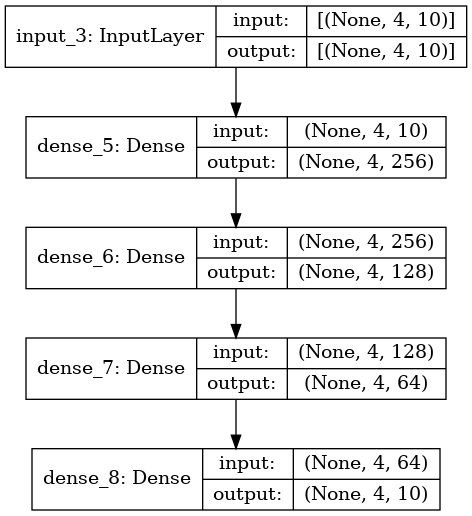

In [8]:
n_perceptrons = 64

model_input = Input(shape=(n_timesteps, n_features))
x = Dense(4*n_perceptrons)(model_input)
x = Dense(2*n_perceptrons)(x)
x = Dense(n_perceptrons)(x)
model_output = Dense(n_features, activation='softmax')(x)

mlp_model = Model(inputs=model_input, outputs=model_output)
mlp_model.compile(loss='categorical_crossentropy', optimizer='adam', 
                  metrics=['accuracy'])
mlp_model.summary()

plot_model(mlp_model, show_shapes=True)

training for  500  epochs begins with validation_split = 0.1 & EarlyStopping(monitor= val_loss, patience=20)....


2021-10-14 17:05:49.678593: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-10-14 17:05:49.928236: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 1999965000 Hz


Epoch 1/500
563/563 - 2s - loss: 2.3084 - accuracy: 0.1010 - val_loss: 2.3057 - val_accuracy: 0.0959
Epoch 2/500
563/563 - 1s - loss: 2.3036 - accuracy: 0.1000 - val_loss: 2.3057 - val_accuracy: 0.0889
Epoch 3/500
563/563 - 1s - loss: 2.3034 - accuracy: 0.0999 - val_loss: 2.3047 - val_accuracy: 0.0927
Epoch 4/500
563/563 - 1s - loss: 2.3034 - accuracy: 0.1004 - val_loss: 2.3045 - val_accuracy: 0.0944
Epoch 5/500
563/563 - 1s - loss: 2.3034 - accuracy: 0.1001 - val_loss: 2.3040 - val_accuracy: 0.0964
Epoch 6/500
563/563 - 1s - loss: 2.3033 - accuracy: 0.0990 - val_loss: 2.3041 - val_accuracy: 0.0945
Epoch 7/500
563/563 - 1s - loss: 2.3032 - accuracy: 0.1021 - val_loss: 2.3037 - val_accuracy: 0.0932
Epoch 8/500
563/563 - 1s - loss: 2.3031 - accuracy: 0.1024 - val_loss: 2.3042 - val_accuracy: 0.0955
Epoch 9/500
563/563 - 1s - loss: 2.3031 - accuracy: 0.1004 - val_loss: 2.3039 - val_accuracy: 0.1007
Epoch 10/500
563/563 - 1s - loss: 2.3029 - accuracy: 0.1021 - val_loss: 2.3035 - val_accura

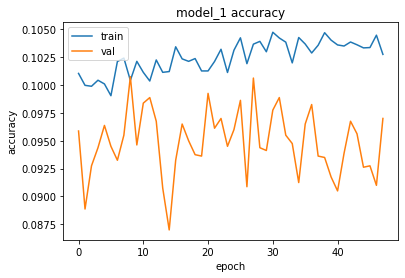

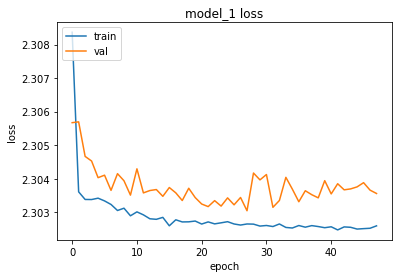

Example predictions...
Input:  [5, 6, 6, 5] Expected: [5, 6, 6, 5] Predicted [5, 5, 5, 5]  False
Input:  [5, 8, 9, 2] Expected: [2, 9, 8, 5] Predicted [5, 1, 0, 0]  False
Input:  [9, 6, 4, 5] Expected: [5, 4, 6, 9] Predicted [0, 5, 5, 5]  False
Input:  [0, 7, 6, 0] Expected: [0, 6, 7, 0] Predicted [3, 8, 5, 3]  False
Input:  [8, 0, 5, 5] Expected: [5, 5, 0, 8] Predicted [1, 3, 5, 5]  False
Input:  [7, 4, 8, 7] Expected: [7, 8, 4, 7] Predicted [8, 5, 1, 8]  False
Input:  [7, 1, 8, 8] Expected: [8, 8, 1, 7] Predicted [8, 1, 1, 1]  False
Input:  [7, 0, 5, 0] Expected: [0, 5, 0, 7] Predicted [8, 3, 5, 3]  False
Input:  [8, 1, 7, 8] Expected: [8, 7, 1, 8] Predicted [1, 1, 8, 1]  False
Input:  [4, 4, 0, 6] Expected: [6, 0, 4, 4] Predicted [5, 5, 3, 5]  False


In [9]:
train_test(mlp_model, X_train, y_train , X_test, y_test, verbose=2)

* We coded a simple Multi-Layer Perceptron (MLP) model by Keras Functional API
* We observed that MLP did not perfom well (about 10% accuracy)
* Using RNN could be a better idea to solve such problems

MLP is not able to learn Seq2Seq Learning. The main reason is that MLP pays attention to all its inputs equally and is not aware of the time dimensionality of the input-output relation. Thus, MLP can not relate input with output understanding the sequence order (time dimension)

### LSTM layer in a Recurrent Neural Network

LSTM has 3 important parameters:

* **units:** Positive integer, the dimensionality of the output space

* **return_sequences:** Boolean, whether to return the last output. In the output sequence, or the full sequence. Default: False.

* **return_state:** Boolean, whether to return the last state in addition to the output. Default: False.

The first parameter (units) indicates the dimension of the output vector/matrix.

The last 2 parameters (return_sequences and return_state) determines what the LSTM layer outputs. LSTM can return 4 different sets of results/states according to the given parameters:

* Default: Last Hidden State (Hidden State of the last time step)
![title](assets/default.png)
* return_sequences=True : All Hidden States (Hidden State of ALL the time steps)
![title](assets/return_sequence.png)
* return_state=True : Last Hidden State+ Last Hidden State (again!) + Last Cell State (Cell State of the last time step)
![title](assets/return_state.png)
* return_sequences=True + return_state=True: All Hidden States (Hidden State of ALL the time steps) + Last Hidden State (again!) + Last Cell State (Cell State of the last time step)
![title](assets/return_sequence+state.png)

Using these 4 different results/states we can stack LSTM layers in various ways

#### 1. LSTM with default output:

In [18]:
n_units = 16

model_input = Input(shape=(n_timesteps, n_features))
x = LSTM(16)(model_input)  # Single LSTM Layer with default output
x = RepeatVector(n_timesteps)(x)  # Repeat the output of LSTM n_timesteps (4 in our example)
model_output = Dense(n_features, activation='softmax')(x)

lstm_model = Model(model_input, model_output)
lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', 
                   metrics=['accuracy'])
lstm_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 4, 10)]           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                1728      
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 4, 16)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 4, 10)             170       
Total params: 1,898
Trainable params: 1,898
Non-trainable params: 0
_________________________________________________________________


training for  500  epochs begins with validation_split = 0.1 & EarlyStopping(monitor= val_loss, patience=20)....
Epoch 1/500
563/563 - 3s - loss: 1.8322 - accuracy: 0.3346 - val_loss: 1.4949 - val_accuracy: 0.3832
Epoch 2/500
563/563 - 1s - loss: 1.4239 - accuracy: 0.3852 - val_loss: 1.3762 - val_accuracy: 0.3834
Epoch 3/500
563/563 - 1s - loss: 1.3342 - accuracy: 0.3853 - val_loss: 1.3082 - val_accuracy: 0.3834
Epoch 4/500
563/563 - 1s - loss: 1.2797 - accuracy: 0.3853 - val_loss: 1.2653 - val_accuracy: 0.3832
Epoch 5/500
563/563 - 1s - loss: 1.2458 - accuracy: 0.3852 - val_loss: 1.2387 - val_accuracy: 0.3832
Epoch 6/500
563/563 - 1s - loss: 1.2251 - accuracy: 0.3851 - val_loss: 1.2231 - val_accuracy: 0.3831
Epoch 7/500
563/563 - 1s - loss: 1.2128 - accuracy: 0.3852 - val_loss: 1.2134 - val_accuracy: 0.3832
Epoch 8/500
563/563 - 1s - loss: 1.2049 - accuracy: 0.3852 - val_loss: 1.2071 - val_accuracy: 0.3834
Epoch 9/500
563/563 - 1s - loss: 1.1996 - accuracy: 0.3852 - val_loss: 1.2027 -

Epoch 81/500
563/563 - 1s - loss: 1.1839 - accuracy: 0.3853 - val_loss: 1.1892 - val_accuracy: 0.3834
Epoch 82/500
563/563 - 1s - loss: 1.1839 - accuracy: 0.3853 - val_loss: 1.1891 - val_accuracy: 0.3834
Epoch 83/500
563/563 - 1s - loss: 1.1839 - accuracy: 0.3853 - val_loss: 1.1892 - val_accuracy: 0.3834
Epoch 84/500
563/563 - 1s - loss: 1.1839 - accuracy: 0.3853 - val_loss: 1.1891 - val_accuracy: 0.3834
Epoch 85/500
563/563 - 1s - loss: 1.1839 - accuracy: 0.3853 - val_loss: 1.1891 - val_accuracy: 0.3834
Epoch 86/500
563/563 - 1s - loss: 1.1839 - accuracy: 0.3853 - val_loss: 1.1891 - val_accuracy: 0.3834
Epoch 87/500
563/563 - 1s - loss: 1.1839 - accuracy: 0.3853 - val_loss: 1.1891 - val_accuracy: 0.3834
Epoch 88/500
563/563 - 1s - loss: 1.1839 - accuracy: 0.3853 - val_loss: 1.1891 - val_accuracy: 0.3834
Epoch 89/500
563/563 - 1s - loss: 1.1839 - accuracy: 0.3853 - val_loss: 1.1891 - val_accuracy: 0.3834
Epoch 90/500
563/563 - 1s - loss: 1.1839 - accuracy: 0.3853 - val_loss: 1.1891 - v

Epoch 161/500
563/563 - 1s - loss: 1.1838 - accuracy: 0.3853 - val_loss: 1.1891 - val_accuracy: 0.3834
Epoch 162/500
563/563 - 1s - loss: 1.1838 - accuracy: 0.3853 - val_loss: 1.1891 - val_accuracy: 0.3834
Epoch 163/500
563/563 - 1s - loss: 1.1838 - accuracy: 0.3853 - val_loss: 1.1890 - val_accuracy: 0.3834
Epoch 164/500
563/563 - 1s - loss: 1.1838 - accuracy: 0.3853 - val_loss: 1.1891 - val_accuracy: 0.3834
Epoch 165/500
563/563 - 1s - loss: 1.1838 - accuracy: 0.3853 - val_loss: 1.1891 - val_accuracy: 0.3834
Epoch 166/500
563/563 - 1s - loss: 1.1838 - accuracy: 0.3853 - val_loss: 1.1890 - val_accuracy: 0.3834
Epoch 167/500
563/563 - 1s - loss: 1.1838 - accuracy: 0.3853 - val_loss: 1.1890 - val_accuracy: 0.3834
Epoch 168/500
563/563 - 1s - loss: 1.1838 - accuracy: 0.3853 - val_loss: 1.1891 - val_accuracy: 0.3834
Epoch 169/500
563/563 - 1s - loss: 1.1838 - accuracy: 0.3853 - val_loss: 1.1891 - val_accuracy: 0.3834
Epoch 170/500
563/563 - 1s - loss: 1.1838 - accuracy: 0.3853 - val_loss: 

Epoch 241/500
563/563 - 1s - loss: 1.1838 - accuracy: 0.3853 - val_loss: 1.1890 - val_accuracy: 0.3834
Epoch 242/500
563/563 - 1s - loss: 1.1838 - accuracy: 0.3853 - val_loss: 1.1890 - val_accuracy: 0.3834
Epoch 243/500
563/563 - 1s - loss: 1.1838 - accuracy: 0.3853 - val_loss: 1.1890 - val_accuracy: 0.3834
Epoch 244/500
563/563 - 1s - loss: 1.1838 - accuracy: 0.3853 - val_loss: 1.1890 - val_accuracy: 0.3834
Epoch 245/500
563/563 - 1s - loss: 1.1838 - accuracy: 0.3853 - val_loss: 1.1890 - val_accuracy: 0.3834
Epoch 246/500
563/563 - 1s - loss: 1.1838 - accuracy: 0.3853 - val_loss: 1.1890 - val_accuracy: 0.3834
Epoch 247/500
563/563 - 1s - loss: 1.1838 - accuracy: 0.3853 - val_loss: 1.1890 - val_accuracy: 0.3834
Epoch 248/500
563/563 - 1s - loss: 1.1838 - accuracy: 0.3853 - val_loss: 1.1890 - val_accuracy: 0.3834
Epoch 249/500
563/563 - 1s - loss: 1.1838 - accuracy: 0.3853 - val_loss: 1.1890 - val_accuracy: 0.3834
Epoch 250/500
563/563 - 1s - loss: 1.1838 - accuracy: 0.3853 - val_loss: 

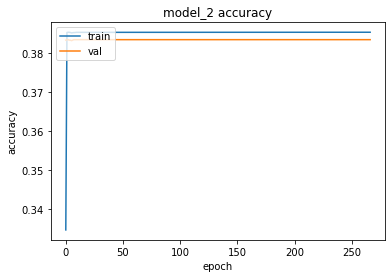

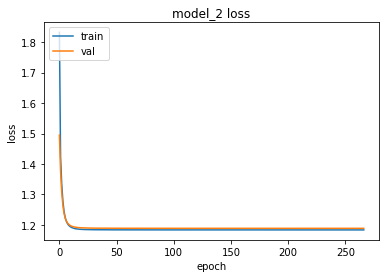

Example predictions...
Input:  [6, 7, 6, 4] Expected: [4, 6, 7, 6] Predicted [6, 6, 6, 6]  False
Input:  [8, 0, 9, 1] Expected: [1, 9, 0, 8] Predicted [9, 9, 9, 9]  False
Input:  [0, 1, 6, 9] Expected: [9, 6, 1, 0] Predicted [1, 1, 1, 1]  False
Input:  [8, 0, 2, 5] Expected: [5, 2, 0, 8] Predicted [8, 8, 8, 8]  False
Input:  [8, 7, 2, 9] Expected: [9, 2, 7, 8] Predicted [2, 2, 2, 2]  False
Input:  [1, 2, 5, 4] Expected: [4, 5, 2, 1] Predicted [4, 4, 4, 4]  False
Input:  [5, 3, 5, 7] Expected: [7, 5, 3, 5] Predicted [5, 5, 5, 5]  False
Input:  [9, 6, 3, 8] Expected: [8, 3, 6, 9] Predicted [8, 8, 8, 8]  False
Input:  [0, 7, 5, 0] Expected: [0, 5, 7, 0] Predicted [0, 0, 0, 0]  False
Input:  [9, 6, 6, 0] Expected: [0, 6, 6, 9] Predicted [6, 6, 6, 6]  False


In [19]:
train_test(lstm_model, X_train, y_train , X_test, y_test, verbose=2)

The accuracy is below 40% for even train data. Thus we need to improve this model by increasing its learning capacity.

In order to increment a model capacity & improve accuracy, in general, we could increment
* number of units
* number of layers
* number of epochs
* number of training samples

We will begin with a model containing multiple LSTM layers which is connected to each other by default output (last hidden states) i.e. the default output (last hidden states) of the first LSTM layer is supplied to the next LSTM layer as inputs!

In [20]:
n_units = 16

model_input = Input(shape=(n_timesteps, n_features))
x = LSTM(16)(model_input)  # First LSTM Layer with default output
x = RepeatVector(n_timesteps)(x)  # Repeat the output of LSTM n_timesteps (4 in our example)

# Second LSTM layer recieves 4 x LSTM outputs as input vector 
# LSTM layer requires 3 dimension input: (batch_size, timesteps, features). Hence, we repeated the output of First LSTM layer
x = LSTM(16)(x)
x = RepeatVector(n_timesteps)(x)
model_output = Dense(n_features, activation='softmax')(x) # Dense layer recieves 4 x LSTM outputs as input vector

lstm_model = Model(model_input, model_output)
lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', 
                   metrics=['accuracy'])
lstm_model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 4, 10)]           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 16)                1728      
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 4, 16)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 16)                2112      
_________________________________________________________________
repeat_vector_3 (RepeatVecto (None, 4, 16)             0         
_________________________________________________________________
dense_11 (Dense)             (None, 4, 10)             170       
Total params: 4,010
Trainable params: 4,010
Non-trainable params: 0
_________________________________________________________

training for  500  epochs begins with validation_split = 0.1 & EarlyStopping(monitor= val_loss, patience=20)....
Epoch 1/500
563/563 - 4s - loss: 1.7279 - accuracy: 0.3383 - val_loss: 1.4346 - val_accuracy: 0.3801
Epoch 2/500
563/563 - 1s - loss: 1.3686 - accuracy: 0.3833 - val_loss: 1.3260 - val_accuracy: 0.3815
Epoch 3/500
563/563 - 1s - loss: 1.2833 - accuracy: 0.3848 - val_loss: 1.2618 - val_accuracy: 0.3824
Epoch 4/500
563/563 - 2s - loss: 1.2373 - accuracy: 0.3849 - val_loss: 1.2289 - val_accuracy: 0.3832
Epoch 5/500
563/563 - 2s - loss: 1.2155 - accuracy: 0.3853 - val_loss: 1.2143 - val_accuracy: 0.3834
Epoch 6/500
563/563 - 2s - loss: 1.2048 - accuracy: 0.3853 - val_loss: 1.2069 - val_accuracy: 0.3834
Epoch 7/500
563/563 - 1s - loss: 1.1988 - accuracy: 0.3853 - val_loss: 1.2023 - val_accuracy: 0.3834
Epoch 8/500
563/563 - 1s - loss: 1.1950 - accuracy: 0.3853 - val_loss: 1.1989 - val_accuracy: 0.3834
Epoch 9/500
563/563 - 1s - loss: 1.1924 - accuracy: 0.3853 - val_loss: 1.1968 -

Epoch 81/500
563/563 - 2s - loss: 1.1839 - accuracy: 0.3853 - val_loss: 1.1891 - val_accuracy: 0.3834
Epoch 82/500
563/563 - 2s - loss: 1.1839 - accuracy: 0.3853 - val_loss: 1.1891 - val_accuracy: 0.3834
Epoch 83/500
563/563 - 2s - loss: 1.1839 - accuracy: 0.3853 - val_loss: 1.1891 - val_accuracy: 0.3834
Epoch 84/500
563/563 - 2s - loss: 1.1839 - accuracy: 0.3853 - val_loss: 1.1891 - val_accuracy: 0.3834
Epoch 85/500
563/563 - 2s - loss: 1.1839 - accuracy: 0.3853 - val_loss: 1.1891 - val_accuracy: 0.3834
Epoch 86/500
563/563 - 2s - loss: 1.1839 - accuracy: 0.3853 - val_loss: 1.1891 - val_accuracy: 0.3834
Epoch 87/500
563/563 - 2s - loss: 1.1839 - accuracy: 0.3853 - val_loss: 1.1891 - val_accuracy: 0.3834
Epoch 88/500
563/563 - 2s - loss: 1.1839 - accuracy: 0.3853 - val_loss: 1.1891 - val_accuracy: 0.3834
Epoch 89/500
563/563 - 2s - loss: 1.1839 - accuracy: 0.3853 - val_loss: 1.1891 - val_accuracy: 0.3834
Epoch 90/500
563/563 - 2s - loss: 1.1839 - accuracy: 0.3853 - val_loss: 1.1891 - v

Epoch 161/500
563/563 - 2s - loss: 1.1838 - accuracy: 0.3853 - val_loss: 1.1891 - val_accuracy: 0.3834
Epoch 162/500
563/563 - 2s - loss: 1.1838 - accuracy: 0.3853 - val_loss: 1.1891 - val_accuracy: 0.3834
Epoch 163/500
563/563 - 2s - loss: 1.1838 - accuracy: 0.3853 - val_loss: 1.1891 - val_accuracy: 0.3834
Epoch 164/500
563/563 - 2s - loss: 1.1838 - accuracy: 0.3853 - val_loss: 1.1890 - val_accuracy: 0.3834
Epoch 165/500
563/563 - 2s - loss: 1.1838 - accuracy: 0.3853 - val_loss: 1.1891 - val_accuracy: 0.3834
Epoch 166/500
563/563 - 2s - loss: 1.1838 - accuracy: 0.3853 - val_loss: 1.1890 - val_accuracy: 0.3834
Epoch 167/500
563/563 - 2s - loss: 1.1838 - accuracy: 0.3853 - val_loss: 1.1891 - val_accuracy: 0.3834
Epoch 168/500
563/563 - 2s - loss: 1.1838 - accuracy: 0.3853 - val_loss: 1.1890 - val_accuracy: 0.3834
Epoch 169/500
563/563 - 2s - loss: 1.1838 - accuracy: 0.3853 - val_loss: 1.1891 - val_accuracy: 0.3834
Epoch 170/500
563/563 - 2s - loss: 1.1838 - accuracy: 0.3853 - val_loss: 

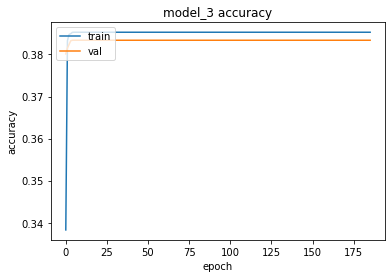

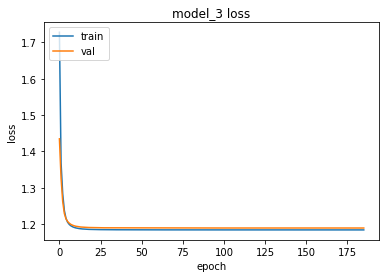

Example predictions...
Input:  [6, 2, 2, 1] Expected: [1, 2, 2, 6] Predicted [2, 2, 2, 2]  False
Input:  [5, 8, 4, 0] Expected: [0, 4, 8, 5] Predicted [8, 8, 8, 8]  False
Input:  [2, 3, 0, 7] Expected: [7, 0, 3, 2] Predicted [7, 7, 7, 7]  False
Input:  [8, 1, 6, 9] Expected: [9, 6, 1, 8] Predicted [6, 6, 6, 6]  False
Input:  [6, 3, 9, 7] Expected: [7, 9, 3, 6] Predicted [6, 6, 6, 6]  False
Input:  [7, 0, 5, 6] Expected: [6, 5, 0, 7] Predicted [7, 7, 7, 7]  False
Input:  [7, 3, 3, 3] Expected: [3, 3, 3, 7] Predicted [3, 3, 3, 3]  False
Input:  [3, 8, 6, 2] Expected: [2, 6, 8, 3] Predicted [2, 2, 2, 2]  False
Input:  [1, 5, 3, 2] Expected: [2, 3, 5, 1] Predicted [3, 3, 3, 3]  False
Input:  [7, 9, 9, 0] Expected: [0, 9, 9, 7] Predicted [9, 9, 9, 9]  False


In [21]:
train_test(lstm_model, X_train, y_train , X_test, y_test, verbose=2)

Test data accuracy (%) did not improve at all. Before trying to increase the capacity of this model, we can use other ways of connecting LSTM layers as follows:

#### 2. LSTM with return_sequences=True output:

Here, we will need to use the TimeDistributed Layer. TimeDistributed Layer allows us to apply the same operation on each time step. For instance, on a video, we may want to apply the same Conv2D on each frame. Then, TimeDistributed layer is used. In Time series, the core idea is the same: we may want to apply an operation on features of each time step. Because it is necessary to keep the time depandancy, we should set **return_sequences=True** before a TimeDistributed layer. 

In [22]:
n_units = 16

model_input = Input(shape=(n_timesteps, n_features))
x = LSTM(16, return_sequences=True)(model_input)  # First LSTM Layer with return_sequences=True

# Output of the first LSTM has 3 dimensions as expected by second LSTM layer. Hence, no RepeatVector is needed.
x = LSTM(16, return_sequences=True)(x)

# Output of the Second LSTM has 3 dimensions. To supply the output to a dense layer, we need to use TimeDistributed layer
model_output = TimeDistributed(Dense(n_features, activation='softmax'))(x) 

lstm_model = Model(model_input, model_output)
lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', 
                   metrics=['accuracy'])
lstm_model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 4, 10)]           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 4, 16)             1728      
_________________________________________________________________
lstm_5 (LSTM)                (None, 4, 16)             2112      
_________________________________________________________________
time_distributed (TimeDistri (None, 4, 10)             170       
Total params: 4,010
Trainable params: 4,010
Non-trainable params: 0
_________________________________________________________________


training for  500  epochs begins with validation_split = 0.1 & EarlyStopping(monitor= val_loss, patience=20)....
Epoch 1/500
563/563 - 5s - loss: 1.8899 - accuracy: 0.2803 - val_loss: 1.6538 - val_accuracy: 0.3239
Epoch 2/500
563/563 - 1s - loss: 1.5839 - accuracy: 0.3293 - val_loss: 1.5397 - val_accuracy: 0.3314
Epoch 3/500
563/563 - 2s - loss: 1.4993 - accuracy: 0.3573 - val_loss: 1.4763 - val_accuracy: 0.3881
Epoch 4/500
563/563 - 2s - loss: 1.4354 - accuracy: 0.4370 - val_loss: 1.4061 - val_accuracy: 0.4780
Epoch 5/500
563/563 - 1s - loss: 1.3649 - accuracy: 0.5110 - val_loss: 1.3386 - val_accuracy: 0.5295
Epoch 6/500
563/563 - 1s - loss: 1.3047 - accuracy: 0.5389 - val_loss: 1.2859 - val_accuracy: 0.5408
Epoch 7/500
563/563 - 1s - loss: 1.2614 - accuracy: 0.5464 - val_loss: 1.2508 - val_accuracy: 0.5445
Epoch 8/500
563/563 - 1s - loss: 1.2291 - accuracy: 0.5500 - val_loss: 1.2192 - val_accuracy: 0.5493
Epoch 9/500
563/563 - 1s - loss: 1.2047 - accuracy: 0.5505 - val_loss: 1.1982 -

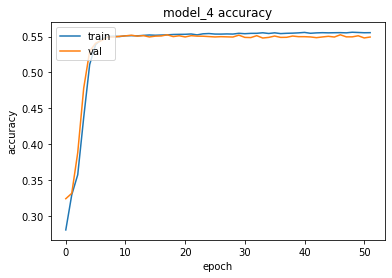

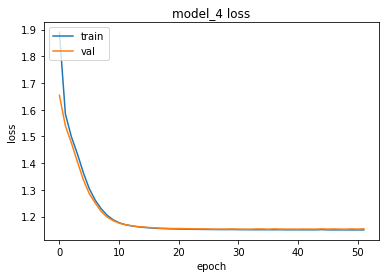

Example predictions...
Input:  [7, 3, 3, 7] Expected: [7, 3, 3, 7] Predicted [9, 8, 3, 7]  False
Input:  [2, 4, 7, 8] Expected: [8, 7, 4, 2] Predicted [2, 0, 4, 2]  False
Input:  [4, 2, 9, 0] Expected: [0, 9, 2, 4] Predicted [6, 4, 2, 4]  False
Input:  [5, 4, 3, 7] Expected: [7, 3, 4, 5] Predicted [4, 4, 4, 5]  False
Input:  [2, 8, 3, 8] Expected: [8, 3, 8, 2] Predicted [2, 2, 8, 2]  False
Input:  [6, 8, 5, 6] Expected: [6, 5, 8, 6] Predicted [9, 4, 8, 6]  False
Input:  [0, 1, 8, 4] Expected: [4, 8, 1, 0] Predicted [9, 6, 1, 0]  False
Input:  [8, 3, 3, 9] Expected: [9, 3, 3, 8] Predicted [2, 3, 3, 8]  False
Input:  [4, 5, 4, 1] Expected: [1, 4, 5, 4] Predicted [6, 3, 5, 4]  False
Input:  [6, 3, 0, 8] Expected: [8, 0, 3, 6] Predicted [9, 6, 3, 6]  False


In [23]:
train_test(lstm_model, X_train, y_train , X_test, y_test, verbose=2)

* Test data Accuracy (%) has improved from 38.34 to 54.94. This tells us that how we connect multiple LSTM layers is important. 
* If we compare the latest model with the previous model it is clear that we are exchanging more information between LSTM layers and also with Dense layers even though the number of parameters are equal.
* In the previous model, we had 16 distinct numbers as the output of the LSTM (i.e. output shape (None, 16)), on the other hand, in the latest model we have 64 (4*16) distinct numbers (i.e. output shape (None, 4, 16)). In the first model, we replicated 16 numbers by 4 times using the RepeatVector layer

Next, we will continue with other ways of connecting LSTM layers.

#### 3. LSTM with return_state=True output:

When return_state=True is set in a LSTM layer, it will return 3 arrays of real numbers:
* LSTM_output (Last Hidden State)
* Last Hidden State (again!)
* Last Cell State (Cell State of the last time step)

We use the 2nd and 3rd outputs of the First LSTM layer to initialize the next LSTM layer’s state = [Last Hidden State + Last Cell State]. Thus, the Second LSTM layer starts with the last state of the First LSTM layer.

As an input for the next LSTM layer, we can use the 1st output [LSTM_output (Last Hidden State)] but since it is 2D (batchsize, features) and the LSTM layer requires 3D (batchsize, timesteps, features) input, we will need to repeat it by timesteps.

In [25]:
n_units = 16

model_input = Input(shape=(n_timesteps, n_features))
x, state_h, state_c = LSTM(16, return_state=True)(model_input)  # First LSTM Layer with return_state=True
states = [state_h, state_c]

x = RepeatVector(n_timesteps)(x)

x = LSTM(16, return_sequences=True)(x, initial_state=states)
model_output = TimeDistributed(Dense(n_features, activation='softmax'))(x)

lstm_model = Model(model_input, model_output)
lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', 
                   metrics=['accuracy'])
lstm_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 4, 10)]      0                                            
__________________________________________________________________________________________________
lstm_6 (LSTM)                   [(None, 16), (None,  1728        input_8[0][0]                    
__________________________________________________________________________________________________
repeat_vector_4 (RepeatVector)  (None, 4, 16)        0           lstm_6[0][0]                     
__________________________________________________________________________________________________
lstm_7 (LSTM)                   (None, 4, 16)        2112        repeat_vector_4[0][0]            
                                                                 lstm_6[0][1]               

training for  500  epochs begins with validation_split = 0.1 & EarlyStopping(monitor= val_loss, patience=20)....
Epoch 1/500
563/563 - 4s - loss: 1.7314 - accuracy: 0.3543 - val_loss: 1.4089 - val_accuracy: 0.4181
Epoch 2/500
563/563 - 1s - loss: 1.2518 - accuracy: 0.4827 - val_loss: 1.0935 - val_accuracy: 0.5558
Epoch 3/500
563/563 - 1s - loss: 0.9776 - accuracy: 0.6047 - val_loss: 0.8726 - val_accuracy: 0.6519
Epoch 4/500
563/563 - 2s - loss: 0.7944 - accuracy: 0.6897 - val_loss: 0.7206 - val_accuracy: 0.7204
Epoch 5/500
563/563 - 2s - loss: 0.6574 - accuracy: 0.7558 - val_loss: 0.5910 - val_accuracy: 0.7875
Epoch 6/500
563/563 - 1s - loss: 0.5403 - accuracy: 0.8127 - val_loss: 0.4840 - val_accuracy: 0.8366
Epoch 7/500
563/563 - 1s - loss: 0.4408 - accuracy: 0.8563 - val_loss: 0.3949 - val_accuracy: 0.8715
Epoch 8/500
563/563 - 1s - loss: 0.3588 - accuracy: 0.8889 - val_loss: 0.3203 - val_accuracy: 0.9045
Epoch 9/500
563/563 - 1s - loss: 0.2923 - accuracy: 0.9146 - val_loss: 0.2641 -

Epoch 80/500
563/563 - 2s - loss: 3.4928e-04 - accuracy: 1.0000 - val_loss: 4.6588e-04 - val_accuracy: 1.0000
Epoch 81/500
563/563 - 2s - loss: 3.2222e-04 - accuracy: 1.0000 - val_loss: 5.0409e-04 - val_accuracy: 1.0000
Epoch 82/500
563/563 - 2s - loss: 0.0047 - accuracy: 0.9988 - val_loss: 0.0013 - val_accuracy: 0.9999
Epoch 83/500
563/563 - 2s - loss: 5.6156e-04 - accuracy: 1.0000 - val_loss: 7.0703e-04 - val_accuracy: 1.0000
Epoch 84/500
563/563 - 2s - loss: 4.0413e-04 - accuracy: 1.0000 - val_loss: 5.6974e-04 - val_accuracy: 1.0000
Epoch 85/500
563/563 - 2s - loss: 3.4807e-04 - accuracy: 1.0000 - val_loss: 4.7657e-04 - val_accuracy: 1.0000
Epoch 86/500
563/563 - 2s - loss: 3.1299e-04 - accuracy: 1.0000 - val_loss: 4.5157e-04 - val_accuracy: 1.0000
Epoch 87/500
563/563 - 2s - loss: 2.9274e-04 - accuracy: 1.0000 - val_loss: 3.9382e-04 - val_accuracy: 1.0000
Epoch 88/500
563/563 - 2s - loss: 2.7076e-04 - accuracy: 1.0000 - val_loss: 4.4626e-04 - val_accuracy: 1.0000
Epoch 89/500
563/5

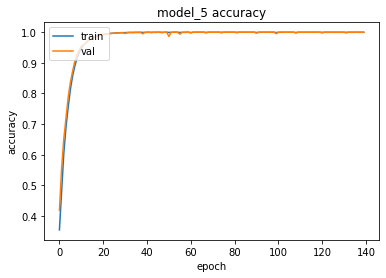

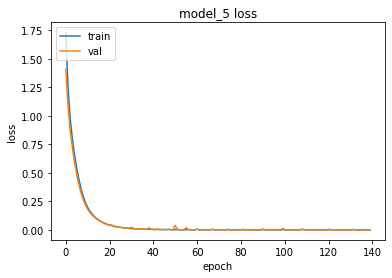

Example predictions...
Input:  [2, 5, 2, 6] Expected: [6, 2, 5, 2] Predicted [6, 2, 5, 2]  True
Input:  [2, 2, 9, 7] Expected: [7, 9, 2, 2] Predicted [7, 9, 2, 2]  True
Input:  [2, 6, 8, 7] Expected: [7, 8, 6, 2] Predicted [7, 8, 6, 2]  True
Input:  [9, 5, 6, 5] Expected: [5, 6, 5, 9] Predicted [5, 6, 5, 9]  True
Input:  [0, 6, 8, 8] Expected: [8, 8, 6, 0] Predicted [8, 8, 6, 0]  True
Input:  [4, 1, 8, 1] Expected: [1, 8, 1, 4] Predicted [1, 8, 1, 4]  True
Input:  [7, 5, 5, 0] Expected: [0, 5, 5, 7] Predicted [0, 5, 5, 7]  True
Input:  [4, 1, 5, 1] Expected: [1, 5, 1, 4] Predicted [1, 5, 1, 4]  True
Input:  [6, 3, 0, 1] Expected: [1, 0, 3, 6] Predicted [1, 0, 3, 6]  True
Input:  [4, 2, 1, 8] Expected: [8, 1, 2, 4] Predicted [8, 1, 2, 4]  True


In [26]:
train_test(lstm_model, X_train, y_train , X_test, y_test, verbose=2)

* Test data Accuracy (%) has massively improved from 38.34 & 54.94 to 100!. (This exceeds our expectations even...)
* If we compare the latest model with the previous models it is clear that we are exchanging more information between LSTM layers even though the number of parameters is the same!
* In the latest model, we do not only provide the output of the previous LSTM layer to the next one, but we also provide the last state of the previous LSTM layer to the next LSTM layer as the initial state!
* In the previous models, we had only provided inputs to the next layer, on the other hand, in the latest model we have also provided initial values for hidden and cell states of the next LSTM layer.

We are still replicating the hidden states 4 times using the RepeatVector layer! In the next model, we will change what we provide as an input to the next layer.

#### 4. LSTM with return_state=True and return_sequences=True output

In LSTMs, when return_sequences=True & return_state=True is set, it will return 3 arrays of real numbers:
* All Hidden States (Hidden State of ALL the time steps)
* Last Hidden State (Hidden State of the last time step)
* Last Cell State (Cell State of the last time step)

As an input for the next LSTM layer, we can use the 1st output [All Hidden States] and since it is 3D (batchsize, timesteps, features) in shape, we do not need to use RepeatVector as we did in the previous model.

The second and the third outputs will be used as the initial states to the Second LSTM layer.

In [27]:
n_units = 16

model_input = Input(shape=(n_timesteps, n_features))
x, state_h, state_c = LSTM(16, return_sequences=True, return_state=True)(model_input)  # First LSTM Layer with return_state=True
states = [state_h, state_c]

x = LSTM(16, return_sequences=True)(x, initial_state=states)
model_output = TimeDistributed(Dense(n_features, activation='softmax'))(x)

lstm_model = Model(model_input, model_output)
lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', 
                   metrics=['accuracy'])
lstm_model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 4, 10)]      0                                            
__________________________________________________________________________________________________
lstm_8 (LSTM)                   [(None, 4, 16), (Non 1728        input_9[0][0]                    
__________________________________________________________________________________________________
lstm_9 (LSTM)                   (None, 4, 16)        2112        lstm_8[0][0]                     
                                                                 lstm_8[0][1]                     
                                                                 lstm_8[0][2]                     
____________________________________________________________________________________________

training for  500  epochs begins with validation_split = 0.1 & EarlyStopping(monitor= val_loss, patience=20)....
Epoch 1/500
563/563 - 4s - loss: 1.6948 - accuracy: 0.3686 - val_loss: 1.3095 - val_accuracy: 0.4490
Epoch 2/500
563/563 - 1s - loss: 1.1158 - accuracy: 0.5364 - val_loss: 0.9714 - val_accuracy: 0.5959
Epoch 3/500
563/563 - 1s - loss: 0.8482 - accuracy: 0.6563 - val_loss: 0.7492 - val_accuracy: 0.7088
Epoch 4/500
563/563 - 2s - loss: 0.6530 - accuracy: 0.7537 - val_loss: 0.5728 - val_accuracy: 0.7945
Epoch 5/500
563/563 - 1s - loss: 0.4986 - accuracy: 0.8272 - val_loss: 0.4420 - val_accuracy: 0.8581
Epoch 6/500
563/563 - 1s - loss: 0.3785 - accuracy: 0.8829 - val_loss: 0.3290 - val_accuracy: 0.9065
Epoch 7/500
563/563 - 1s - loss: 0.2810 - accuracy: 0.9236 - val_loss: 0.2412 - val_accuracy: 0.9367
Epoch 8/500
563/563 - 1s - loss: 0.2040 - accuracy: 0.9515 - val_loss: 0.1721 - val_accuracy: 0.9649
Epoch 9/500
563/563 - 1s - loss: 0.1470 - accuracy: 0.9705 - val_loss: 0.1231 -

Epoch 77/500
563/563 - 2s - loss: 4.1705e-05 - accuracy: 1.0000 - val_loss: 5.0785e-05 - val_accuracy: 1.0000
Epoch 78/500
563/563 - 1s - loss: 3.5930e-05 - accuracy: 1.0000 - val_loss: 4.5006e-05 - val_accuracy: 1.0000
Epoch 79/500
563/563 - 2s - loss: 3.1415e-05 - accuracy: 1.0000 - val_loss: 4.1597e-05 - val_accuracy: 1.0000
Epoch 80/500
563/563 - 2s - loss: 2.7788e-05 - accuracy: 1.0000 - val_loss: 3.6472e-05 - val_accuracy: 1.0000
Epoch 81/500
563/563 - 2s - loss: 2.4752e-05 - accuracy: 1.0000 - val_loss: 3.3451e-05 - val_accuracy: 1.0000
Epoch 82/500
563/563 - 2s - loss: 2.2141e-05 - accuracy: 1.0000 - val_loss: 2.9041e-05 - val_accuracy: 1.0000
Epoch 83/500
563/563 - 2s - loss: 1.9902e-05 - accuracy: 1.0000 - val_loss: 2.6519e-05 - val_accuracy: 1.0000
Epoch 84/500
563/563 - 2s - loss: 1.7983e-05 - accuracy: 1.0000 - val_loss: 2.4523e-05 - val_accuracy: 1.0000
Epoch 85/500
563/563 - 2s - loss: 1.6127e-05 - accuracy: 1.0000 - val_loss: 2.1577e-05 - val_accuracy: 1.0000
Epoch 86/5

563/563 - 2s - loss: 4.5270e-06 - accuracy: 1.0000 - val_loss: 9.1689e-06 - val_accuracy: 1.0000
Epoch 152/500
563/563 - 2s - loss: 3.9252e-06 - accuracy: 1.0000 - val_loss: 7.7778e-06 - val_accuracy: 1.0000
Epoch 153/500
563/563 - 2s - loss: 3.4116e-06 - accuracy: 1.0000 - val_loss: 6.9021e-06 - val_accuracy: 1.0000
Epoch 154/500
563/563 - 2s - loss: 2.9690e-06 - accuracy: 1.0000 - val_loss: 5.9174e-06 - val_accuracy: 1.0000
Epoch 155/500
563/563 - 2s - loss: 2.5906e-06 - accuracy: 1.0000 - val_loss: 5.1247e-06 - val_accuracy: 1.0000
Epoch 156/500
563/563 - 2s - loss: 2.2691e-06 - accuracy: 1.0000 - val_loss: 4.5017e-06 - val_accuracy: 1.0000
Epoch 157/500
563/563 - 2s - loss: 1.9902e-06 - accuracy: 1.0000 - val_loss: 3.9955e-06 - val_accuracy: 1.0000
Epoch 158/500
563/563 - 2s - loss: 1.7528e-06 - accuracy: 1.0000 - val_loss: 3.4720e-06 - val_accuracy: 1.0000
Epoch 159/500
563/563 - 2s - loss: 1.5514e-06 - accuracy: 1.0000 - val_loss: 3.0599e-06 - val_accuracy: 1.0000
Epoch 160/500
5

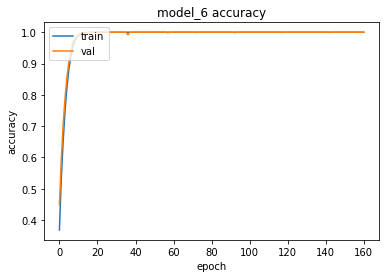

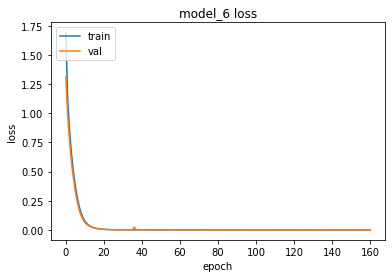

Example predictions...
Input:  [3, 1, 0, 5] Expected: [5, 0, 1, 3] Predicted [5, 0, 1, 3]  True
Input:  [9, 5, 5, 4] Expected: [4, 5, 5, 9] Predicted [4, 5, 5, 9]  True
Input:  [8, 4, 9, 8] Expected: [8, 9, 4, 8] Predicted [8, 9, 4, 8]  True
Input:  [2, 1, 1, 6] Expected: [6, 1, 1, 2] Predicted [6, 1, 1, 2]  True
Input:  [9, 4, 6, 8] Expected: [8, 6, 4, 9] Predicted [8, 6, 4, 9]  True
Input:  [6, 1, 3, 6] Expected: [6, 3, 1, 6] Predicted [6, 3, 1, 6]  True
Input:  [2, 5, 9, 7] Expected: [7, 9, 5, 2] Predicted [7, 9, 5, 2]  True
Input:  [5, 6, 7, 1] Expected: [1, 7, 6, 5] Predicted [1, 7, 6, 5]  True
Input:  [3, 4, 0, 6] Expected: [6, 0, 4, 3] Predicted [6, 0, 4, 3]  True
Input:  [3, 9, 6, 5] Expected: [5, 6, 9, 3] Predicted [5, 6, 9, 3]  True


In [28]:
train_test(lstm_model, X_train, y_train , X_test, y_test, verbose=2)

As expected, the accuracy on the test data is 100 which is great news!

In the latest model, we have provided:
* previous LSTM’s last hidden and cell states as initial values to the next LSTM layer’s hidden and cell states.
* previous LSTM’s all hidden states as inputs to the next LSTM layer

In other words, second LSTM layer:
* starts to operate with the last hidden states and cell states of the first LSTM layer
* consumes the first LSTM layer’s all hidden states to produce the output

As a result, during training:
* The second LSTM layer is conditioned to produce expected outputs given the first LSTM layer’s outputs.
* The first LSTM layer is conditioned to produce such outputs that the second LSTM layer would be successful in prediction.

Thus:
* We can argue that the first LSTM layer encodes the input (X) in a representation that the second LSTM layer can decode it to produce the expected output (y)
* The encoded representation of the input (X) in the last model is composed of the all hidden states + last hidden + cell states


#### Now a few questions that might arise:
* When n_timesteps is 4, the model is able to achieve 97.3% accuracy
* What if we set n_timesteps to 8?
* What if we set n_timesteps to 16?

Actually, the performance of the models starts to decrease when we request them to deal with longer sequences. So, how to handle longer sequences?

A generic Solution would be to increment the model capacity!

In order to increment a model capacity & improve accuracy, we could
* increment number of units
* increment number of layers
* increment number of epochs
* increment number of training samples

However, even the length of the input sequence is increased a little bit (e.g. from 4 to 8) and the model can not catch up with it to provide similar accuracy applying all the above measures.

So in conclusion, LSTM layers cannot handle/remember/relate longer sequences. 

#### A few more questions can arise:
* How can we create a model to handle variable-length input/output? Here all the inputs and outputs already had a fixed length.
* How can you train such a model?

One alternative we can think of is that we can use padding (i.e. adding some special symbol (e.g. zero) in front of or at the end of each sequence such that all sequences have an equal length with the maximum sequence length in the dataset).

However, there are plenty of drawbacks to this solution:
* Waste of space and computation power
* In real life, sometimes we do NOT know the maximum sequence length
* In some applications, the input sequence is continuous (e.g. speech recognition). Thus, we cannot wait until the end of the sequence to process (i.e. padding) it!

So, we would maybe need a better alternative model architecture to mitigate all these drawbacks.